# Simulating atmospheric absorption, and fitting it to a building spectrum using PySMARTS (SMARTS wrapped in python)

In [1]:
# -- importing necessary libraries

import os
import math
import numpy as np
import pandas as pd
import random
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import CustomJS, Div, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.events import Tap
import time
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pysmarts
import emcee
import corner

In [2]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

## Read Cube

In [3]:
# -- read the cube from .raw file into float array

fname = "../../../image_files/veg_00108.raw"
cube = read_hyper(fname)
cube_sub = cube.data[:, :, :].astype(float)

reading and parsing ../../../image_files/veg_00108.hdr...
reading ../../../image_files/veg_00108.raw...


In [ ]:
## -- Plot cube
lam   = [610.,540.,475.]
bands = [np.arange(cube.waves.size)[(cube.waves>=(tlam-10.))&(cube.waves<(tlam+10.))] for tlam in lam]
red   = cube.data[bands[0]].mean(0)
grn   = cube.data[bands[1]].mean(0)
blu   = cube.data[bands[2]].mean(0)
red8  = red*2.**8/2.**12
grn8  = grn*2.**8/2.**12
blu8  = blu*2.**8/2.**12

In [ ]:
wr    = red.mean()
wg    = grn.mean()
wb    = blu.mean()
scl   = np.array([wr,wg,wb])
scl  /= scl.max()
scl  /= np.array([0.9,1.0,1.0])
amp   = 1.0
rgb8  = (amp*np.dstack([red8,grn8,blu8])/scl).clip(0,255).astype(np.uint8)

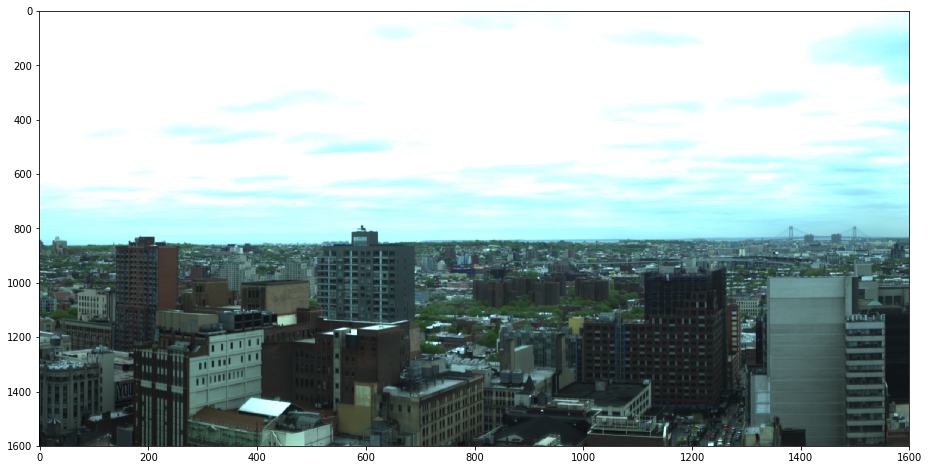

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=[16,8])
#fig.subplots_adjust(0.05,0.05,0.95,0.95)
#ax.axis("off")
im = ax.imshow(rgb8,aspect=0.5,interpolation="nearest")
fig.canvas.draw()

In [ ]:
rgba = np.pad(rgb8, [(0, 0), (0, 0), (0, 1)], mode='constant', constant_values=255.)
rgba = np.flip(rgba.astype(np.uint8), axis=0)

In [ ]:
# -- an interactive plot that shows the coordinates of mouse clicks

output_notebook()

def display_event(div, attributes=[], style = 'float:left;clear:left;font_size=10pt'):
    "Build a suitable CustomJS to display the current event in the div model."
    return CustomJS(args=dict(div=div), code="""
        var attrs = %s; var args = [];
        for (var i = 0; i<attrs.length; i++) {
            args.push(Number(cb_obj[attrs[i]]).toFixed(2));
        }
        var line = "<span style=%r>(" + args.join(", ") + ")</span>\\n";
        var text = div.text.concat(line);
        var lines = text.split("\\n")
        if (lines.length > 35)
            lines.shift();
        div.text = lines.join("\\n");
    """ % (attributes, style))
      

source_data = dict(image=[rgba],
                  x=[0],
                  y=[-1600],
                  dw=[1600],
                  dh=[1600])

p = figure(plot_width=800, plot_height=400, x_range=(0,1600), y_range=(-1600,0), tools=['pan','tap','box_zoom','wheel_zoom','save','reset'])
p.image_rgba(source=source_data, image='image', x='x', y='y', dw='dw', dh='dh')

div = Div(width=400, height=p.plot_height)
layout = row(p, div)

point_attributes = ['y', 'x']
p.js_on_event(Tap, display_event(div, attributes=point_attributes))

show(layout)

(25, 2)


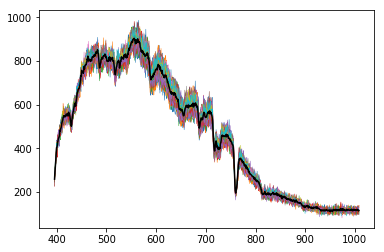

In [4]:
# -- choosing 5x5 pixels in building adjacent to vegetation
#    taking mean of spectra to use for fitting

brow = np.arange(1015,1020)
bcol = np.arange(847,852)
bcoords = np.vstack(np.meshgrid(brow, bcol)).reshape(2,-1).T
print(bcoords.shape)
for coord in bcoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
blds = cube.data[:,1015:1020,847:852].mean(axis=(1,2))
plt.plot(cube.waves, blds, color='black')
plt.show()

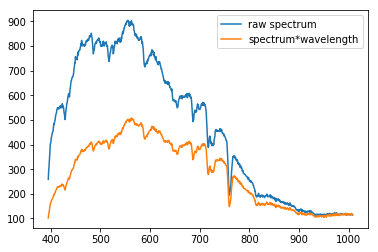

In [5]:
# -- multiplying mean building spectrum by wavelength
nblds = blds*cube.waves/1e3
plt.plot(cube.waves, blds, label='raw spectrum')
plt.plot(cube.waves, nblds, label='spectrum*wavelength')
plt.legend()
plt.show()

## Using SMARTS

In [6]:
def modelFunc(scan, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, 
              a4, b4, c4, d4, W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, 
              ApNO, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5):
# -- Function to call pySMARTS and produce a model
    nalb = 111
    mywav = np.linspace(0.35,0.9,nalb)
    np.around(mywav, 2, mywav)
    albedo = albedoFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    err_set = np.seterr(all='ignore')
    np.around(albedo, 4, albedo)

    
    if scan == '108':
        Year = 2016
        Month = 5
        Day = 5
        Hour = 14.02
    elif scan == '000':
        Year = 2016
        Month = 5
        Day = 2
        Hour = 17.77
    
    albwav = np.zeros(shape=(3000))
    albalb = np.zeros(shape=(3000))
    l = np.zeros(shape=(14,636))
    albwav[:nalb] = mywav
    albalb[:nalb] = albedo
    
    pymod = pysmarts.smarts295(W, ApCH2O, ApCH4, ApCO, ApHNO2, 
                               ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5, 
                               1, 1, albwav, albalb, nalb, Year, Month, Day, Hour, l)
    
    return pymod[0], pymod[-2]

In [7]:
def albedoFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4):
# -- Function to produce an albedo array
    err_set = np.seterr(all='raise')
    try:
        albedo = (b1*np.exp(-((wav-a1)**2)/(2*(c1**2)))+d1) + (b2*np.exp(-((wav-a2)**2)/(2*(c2**2)))+d2) + \
                (b3*np.exp(-((wav-a3)**2)/(2*(c3**2)))+d3) + (b4*np.exp(-((wav-a4)**2)/(2*(c4**2)))+d4)
    except:
        albedo = np.full(len(wav), -np.inf)
        
    return np.array(albedo)

In [8]:
def interpModel(mywav, amp, modelwav, modelsmrt):
# -- Function to interpolate the pySMARTS model into the cube's wavelengths
#    and multiply by the given amplitude
    err_set = np.seterr(all='raise')
    try:
        interpMod = interp1d(modelwav, modelsmrt, fill_value="extrapolate")
        model = np.array(interpMod(mywav)) * amp
    except:
        model = np.full(len(mywav), -np.inf)
    
    return model

In [9]:
a1 = 0.62
b1 = 0.159
c1 = 0.114
d1 = 0.10

a2 = 0.755
b2 = 0.0748
c2 = 0.045
d2 = -0.01

a3 = 1.9
b3 = 0.111
c3 = 1.049
d3 = 0.0001

a4 = 0.584
b4 = 0.07
c4 = 0.11
d4 = 0.0001

#TAIR = 15.5
#RH = 69.0
#TDAY = 12.5

W = 2.0
# In units of atm-cm
ApCH2O = 0.0007
ApCH4 = 0.03
ApCO = 0.035
ApHNO2 = 0.0002
ApHNO3 = 0.0005
ApNO = 0.02
ApNO2 = 0.002
ApNO3 = 5e-6
AbO3 = 0.33
ApO3 = 0.0053
ApSO2 = 0.005

qCO2 = 370.0
#ALPHA1 = 0.9111
#ALPHA2 = 1.3529
#OMEGL = 0.8
#GG = 0.7
TAU5 = 0.084
    
amp = 1999.5
eps = 18.5

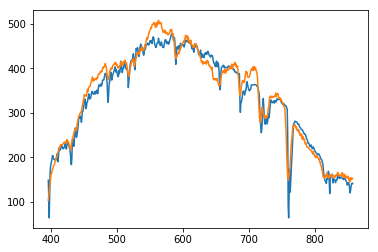

In [12]:
scan = '108'
mywav = cube.waves[:-200]
myblds = nblds[:-200]
smrtwav, smrtmod = modelFunc(scan, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, 
              a4, b4, c4, d4, W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, 
              ApNO, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5)
maxmod = interpModel(mywav, amp, smrtwav, smrtmod)
plt.plot(mywav, maxmod)
plt.plot(mywav, myblds)

In [13]:
def log_prior(theta, wav):
#    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
#    W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, \
#    ApSO2, qCO2, TAU5, amp, eps = theta
    
#    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, amp, eps = theta
#    W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5, amp, eps = theta
    W, ApHNO2, ApNO2, ApNO3, AbO3, ApO3, ApSO2, TAU5, amp, eps = theta
    
    if eps <= 0:
        return -np.inf
#    if (c1 == 0) or (c2 == 0) or (c3 == 0) or (c4 == 0):
#        return -np.inf
#    if (a1 < 0.6 ) or (a1 >= 0.7):
#        return -np.inf
#    if (a2 < 0.7 ) or (a2 >= 1.0):
#        return -np.inf
#    if (a3 < 1.0 ) or (a4 >= 0.6):
#        return -np.inf
    if (amp <= 0):
        return -np.inf
#    nwav = np.linspace(0.35,0.9,111)
#    albedo = albedoFunc(nwav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
#    if any(np.isnan(albedo)) or not any(np.isfinite(albedo)):
#        return -np.inf
#    if (any(albedo) < 0) or (any(albedo) > 1):
#        return -np.inf
    if (W < 0) or (W > 12):
        return -np.inf
#    if (ApCH2O < 0) or (ApCH2O > 5.0):
#        return -np.inf
#    if (ApCH4 < 0) or (ApCH4 > 5.0):
#        return -np.inf
#    if (ApCO < 0) or (ApCO > 5.0):
#        return -np.inf
    if (ApHNO2 < 0) or (ApHNO2 > 5.0):
        return -np.inf
#    if (ApHNO3 < 0) or (ApHNO3 > 5.0):
#        return -np.inf
#    if (ApNO < 0) or (ApNO > 5.0):
#        return -np.inf
    if (ApNO2 < 0) or (ApNO2 > 5.0):
        return -np.inf
    if (ApNO3 < 0) or (ApNO3 > 5.0):
        return -np.inf
    if (AbO3 < 0) or (AbO3 > 5.0):
        return -np.inf
    if (ApO3 < 0) or (ApO3 > 5.0):
        return -np.inf
    if (ApSO2 < 0) or (ApSO2 > 5.0):
        return -np.inf
#    if (qCO2 < 0) or (qCO2 > 1000):
#        return -np.inf
    if (TAU5 < 0) or (TAU5 > 5.57):
        return -np.inf

    a1 = 0.62
    b1 = 0.159
    c1 = 0.114
    d1 = 0.10

    a2 = 0.755
    b2 = 0.0748
    c2 = 0.045
    d2 = -0.01

    a3 = 1.9
    b3 = 0.111
    c3 = 1.049
    d3 = 0.0001

    a4 = 0.584
    b4 = 0.07
    c4 = 0.11
    d4 = 0.0001

    ApCH2O = 0.0
    ApCH4  = 0.0
    ApCO   = 0.0
    ApHNO3 = 0.0
    ApNO   = 0.0
    qCO2   = 0.0

#    W = 2.0
#    ApCH2O = 0.007
#    ApCH4 = 0.3
#    ApCO = 0.35
#    ApHNO2 = 0.002
#    ApHNO3 = 0.005
#    ApNO = 0.2
#    ApNO2 = 0.02
#    ApNO3 = 5e-5
#    ApO3 = 0.053
#    AbO3 = 0.33
#    ApSO2 = 0.05
#    qCO2 = 370.0
#    TAU5 = 0.084
        
    modwav, modsmrt = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                                W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3,
                                ApSO2, qCO2, TAU5)
    if any(np.isnan(modsmrt)) or not any(np.isfinite(modsmrt)):
        modwav, modsmrt = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                                    W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, 
                                    ApSO2, qCO2, TAU5)
        if any(np.isnan(modsmrt)) or not any(np.isfinite(modsmrt)):
            return -np.inf
    
    model = interpModel(wav, amp, modwav, modsmrt)
    if (any(model) < 0) or any(np.isnan(model)) or not any(np.isfinite(model)):
        return -np.inf
    return 0.0

In [20]:
def log_likelihood(theta, wav, y):  
#    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
#    W, ApCH2O, ApCH4, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, \
#    ApSO2, qCO2, TAU5, amp, eps = theta
    
#    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, amp, eps = theta
#    W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5, amp, eps = theta
    W, ApHNO2, ApNO2, ApNO3, AbO3, ApO3, ApSO2, TAU5, amp, eps = theta
    
    lp = log_prior(theta, mywav)
    if not np.isfinite(lp):
#        print("LOG_PROBABILITY = ", -np.inf)
        return -np.inf

    a1 = 0.62
    b1 = 0.159
    c1 = 0.114
    d1 = 0.10

    a2 = 0.755
    b2 = 0.0748
    c2 = 0.045
    d2 = -0.01

    a3 = 1.9
    b3 = 0.111
    c3 = 1.049
    d3 = 0.0001

    a4 = 0.584
    b4 = 0.07
    c4 = 0.11
    d4 = 0.0001

    ApCH2O = 0.0
    ApCH4  = 0.0
    ApCO   = 0.0
    ApHNO3 = 0.0
    ApNO   = 0.0
    qCO2   = 0.0
    
#    W = 2.0
#    ApCH2O = 0.007
#    ApCH4 = 0.3
#    ApCO = 0.35
#    ApHNO2 = 0.002
#    ApHNO3 = 0.005
#    ApNO = 0.2
#    ApNO2 = 0.02
#    ApNO3 = 5e-5
#    ApO3 = 0.053
#    AbO3 = 0.33
#    ApSO2 = 0.05
#    qCO2 = 370.0
#    TAU5 = 0.084
    
    modwav, modsmrt = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                                W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3,
                                ApSO2, qCO2, TAU5)
    if any(np.isnan(modsmrt)) or not any(np.isfinite(modsmrt)):
        modwav, modsmrt = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                                    W, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, 
                                    ApSO2, qCO2, TAU5)
        if any(np.isnan(modsmrt)) or not any(np.isfinite(modsmrt)):
            return -np.inf
    
    model = interpModel(wav, amp, modwav, modsmrt)
    if any(np.isnan(model)) or not any(np.isfinite(model)) or (any(model) < 0):
        return -np.inf
        
    denom = eps**2
    lk = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lk

In [21]:
## -- Maximum Likelihood function

def MaxLikFunc(blds, wav, W, ApHNO2, ApNO2, ApNO3, AbO3, ApO3, ApSO2, TAU5, amp):
    #np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([W, ApHNO2, ApNO2, ApNO3, AbO3, ApO3, ApSO2, TAU5, amp, 20.])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [23]:
import time
start_time = time.time()
result = MaxLikFunc(nblds[:-200], cube.waves[:-200], W, ApHNO2, ApNO2, ApNO3, AbO3, ApO3, ApSO2, TAU5, amp)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

[2.0000e+00 2.0000e-04 2.0000e-03 5.0000e-06 3.3000e-01 5.3000e-03
 5.0000e-03 8.4000e-02 1.9995e+03 2.0000e+01]
00:00:01


In [10]:
# -- using standard concrete albedo 

l0 = np.zeros(shape=(14,636))
#c = np.zeros(shape=(6,851))
albwav = np.zeros(shape=(3000))
albalb = np.zeros(shape=(3000))

import time
t0 = time.time()
l = pysmarts.smarts295(20,70,18, 10.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                       5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,18,18,
                       albwav, albalb, 101, 2016,5,5,14.02,l0)
print(time.time() - t0)

0.041188716888427734


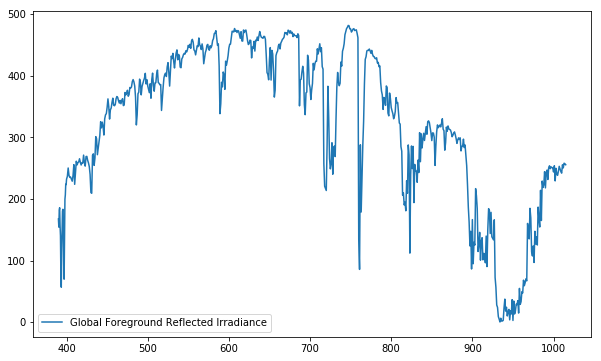

In [11]:
fig = plt.subplots(figsize=(10,6))
plt.plot(l[0], l[-2]*2100, label='Global Foreground Reflected Irradiance')
#plt.plot(cube.waves, blds*0.5, label='Mean Building Spectrum (Raw)')
#plt.plot(cube.waves, nblds, color='black', label='Mean Building Spectrum (*wavelength)')
plt.legend()
plt.show()

## ALBEDO

In [17]:
albfiles = !ls ./Albedo/

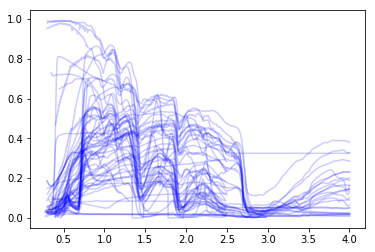

In [18]:
for file in albfiles:
    filename = './Albedo/' + file
    alb = pd.read_csv(filename, sep='\t', header=None, names=['wav', 'alb'])
    plt.plot(alb['wav'], alb['alb'], color='b', alpha=0.2)
plt.show()

In [19]:
albfiles = !ls ./myAlbedo/
alb = {}
for file in albfiles:
    filename = './myAlbedo/' + file
    alb[file] = pd.read_csv(filename, sep='\t', header=None, names=['wav', 'alb'])

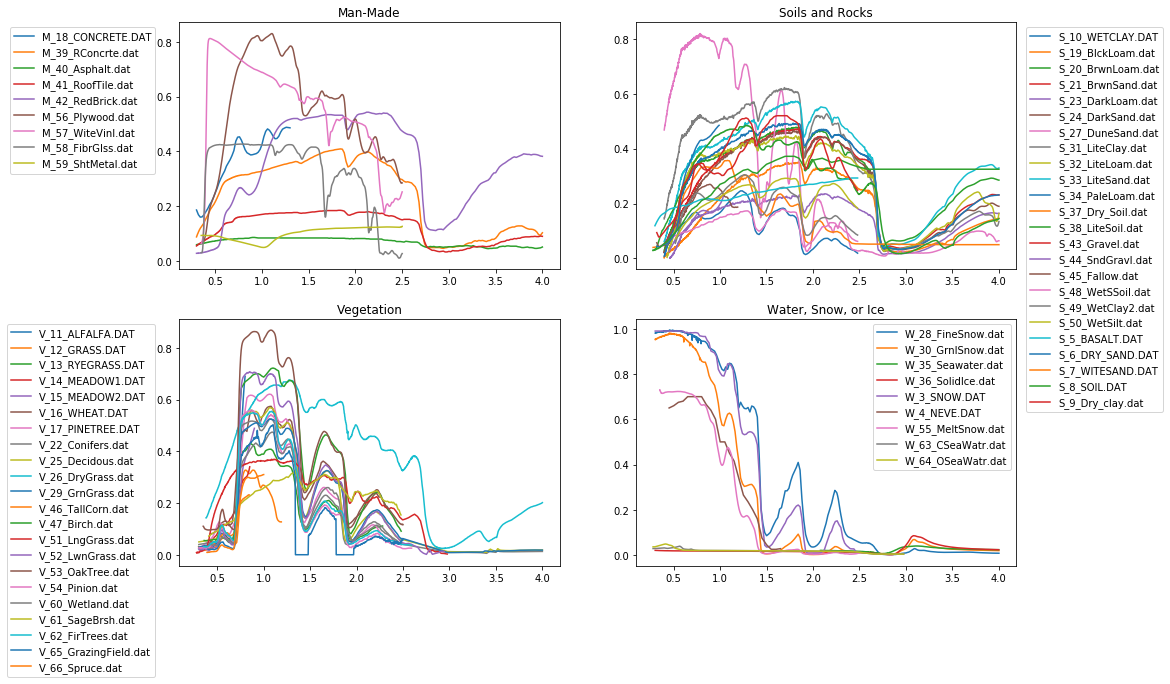

In [20]:
fig, ((axM, axS), (axV, axW)) = plt.subplots(2, 2, figsize=(15,10))

axM.set_title('Man-Made')
axS.set_title('Soils and Rocks')
axV.set_title('Vegetation')
axW.set_title('Water, Snow, or Ice')

for key in alb.keys():
    if key.startswith('M'):
        axM.plot(alb[key]['wav'], alb[key]['alb'], label=key)
    if key.startswith('S'):
        axS.plot(alb[key]['wav'], alb[key]['alb'], label=key)
    if key.startswith('V'):
        axV.plot(alb[key]['wav'], alb[key]['alb'], label=key)
    if key.startswith('W'):
        axW.plot(alb[key]['wav'], alb[key]['alb'], label=key)
        
axM.legend(loc='upper right', bbox_to_anchor=(-0.05,1))
axS.legend(loc='upper right', bbox_to_anchor=(1.4,1))
axV.legend(loc='upper right', bbox_to_anchor=(-0.05,1))
axW.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.show()

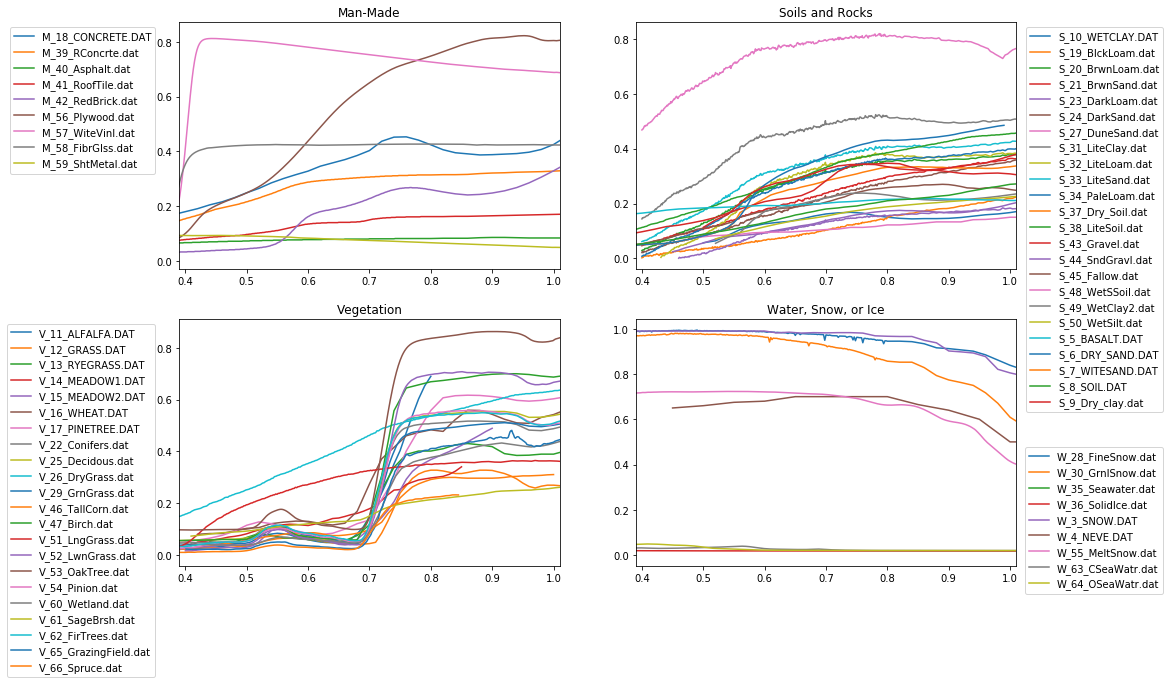

In [21]:
fig, ((axM, axS), (axV, axW)) = plt.subplots(2, 2, figsize=(15,10))

axM.set_title('Man-Made')
axS.set_title('Soils and Rocks')
axV.set_title('Vegetation')
axW.set_title('Water, Snow, or Ice')

for key in alb.keys():
    if key.startswith('M'):
        axM.plot(alb[key]['wav'], alb[key]['alb'], label=key)
    if key.startswith('S'):
        axS.plot(alb[key]['wav'], alb[key]['alb'], label=key)
    if key.startswith('V'):
        axV.plot(alb[key]['wav'], alb[key]['alb'], label=key)
    if key.startswith('W'):
        axW.plot(alb[key]['wav'], alb[key]['alb'], label=key)

axM.set_xlim(0.390,1.010)
axS.set_xlim(0.390,1.010)
axV.set_xlim(0.390,1.010)
axW.set_xlim(0.390,1.010)
        
axM.legend(loc='upper right', bbox_to_anchor=(-0.05,1))
axS.legend(loc='upper right', bbox_to_anchor=(1.4,1))
axV.legend(loc='upper right', bbox_to_anchor=(-0.05,1))
axW.legend(loc='upper right', bbox_to_anchor=(1.4,0.5))
plt.show()

In [22]:
conc_alb = pd.read_csv('./Albedo/CONCRETE.DAT', sep='\t', header=None, names=['wav', 'alb'])

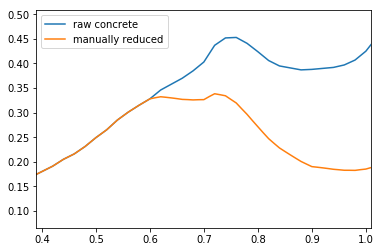

In [23]:
myalbed = pd.read_csv('./Albedo/myALBEDO.DAT', sep='\t', header=None, names=['wav', 'alb'])
plt.plot(conc_alb['wav'], conc_alb['alb'], label='raw concrete')
plt.plot(myalbed['wav'], myalbed['alb'], label='manually reduced')
plt.xlim(0.390,1.010)
plt.legend()
plt.show()

In [ ]:
# -- write custom albedo to ALBEDO.DAT file

tocsv = pd.DataFrame(myalbed)
tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

In [24]:
myalbed = pd.read_csv('./Albedo/myALBEDO.DAT', sep='\t', header=None, names=['wav', 'alb'])

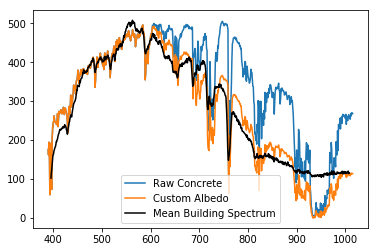

In [25]:
albwav = np.zeros(shape=(3000))
albalb = np.zeros(shape=(3000))

l1 = np.zeros(shape=(14,636))
#c1 = np.zeros(shape=(6,851))

l1 = pysmarts.smarts295(20,20,18, 10.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                        5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,18,18,
                        albwav, albalb, 101, 2016,5,5,14.02,l1)

nalb = len(myalbed['wav'].values[:-1])
albwav[:nalb] = myalbed['wav'].values[:-1]
albalb[:nalb] = myalbed['alb'].values[:-1]

l2 = np.zeros(shape=(14,636))
#c2 = np.zeros(shape=(6,851))
l2 = pysmarts.smarts295(20,20,18, 10.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         albwav, albalb, nalb, 2016,5,5,14.02,l2)


plt.plot(l1[0], l1[-2]*2200, label='Raw Concrete')
plt.plot(l2[0], l2[-2]*2200, label='Custom Albedo')
plt.plot(cube.waves, nblds, color='black', label='Mean Building Spectrum')
plt.legend()
plt.show()

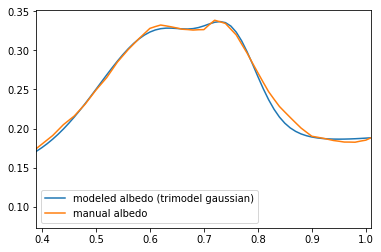

In [26]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = np.array(myalbed['wav'])
y = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
     (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
plt.plot(x, y, label='modeled albedo (trimodel gaussian)')
plt.plot(myalbed['wav'], myalbed['alb'], label='manual albedo')
plt.xlim(0.390,1.010)
plt.legend()
plt.show()

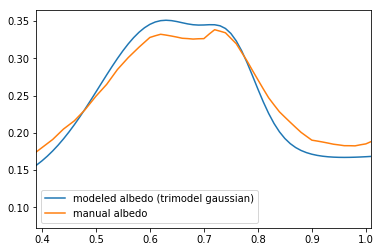

In [27]:
a1 = 0.62
b1 = 1.3
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = -0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = np.array(myalbed['wav'])
y = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
     (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
plt.plot(x, y, label='modeled albedo (trimodel gaussian)')
plt.plot(myalbed['wav'], myalbed['alb'], label='manual albedo')
plt.xlim(0.390,1.010)
plt.legend()
plt.show()

In [ ]:
# -- using least squares fit to find minimums for albedo

#def albedoFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3):
#    albedo = ((b1/(2*np.pi))*np.exp(-((wav-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((wav-a2)**2)/(2*c2))+d2) + \
#    ((b3/(2*np.pi))*np.exp(-((wav-a3)**2)/(2*c3))+d3)
#    
#    return np.array(albedo)

In [18]:
def modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
              TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, 
              ApO3, ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5):
    nalb = 101
    mywav = np.linspace(0.3,1.3,nalb)
    np.around(mywav, 2, mywav)
    albedo = albedoFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    np.around(albedo, 4, albedo)

    #TAIR = 15.5
    #RH = 69.0
    #TDAY = 12.5
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    albwav = np.zeros(shape=(3000))
    albalb = np.zeros(shape=(3000))
    l = np.zeros(shape=(14,636))
    #c = np.zeros(shape=(6,851))
    albwav[:nalb] = mywav
    albalb[:nalb] = albedo
    
    pymod = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, 0.0, ApCO, ApHNO2,
                               ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2,
                               ALPHA1, ALPHA2, OMEGL, GG, TAU5, 1, 1,
                               albwav, albalb, nalb, Year, Month, Day, Hour, l)
    
#    interp_l = interp1d(pymod[0], pymod[-2], fill_value="extrapolate")
#    model = np.array(interp_l(wav)) * amp
    
    return pymod[0], pymod[-2]

In [16]:
def interpModel(mywav, amp, modelwav, modelsmrt):
    interpMod = interp1d(modelwav, modelsmrt, fill_value="extrapolate")
    model = np.array(interpMod(mywav)) * amp
    
    return model

In [17]:
# -- using least squares fit to find minimums for albedo

def albedoFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4):
    albedo = ((b1/(2*np.pi))*np.exp(-((wav-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((wav-a2)**2)/(2*c2))+d2) + \
    ((b3/(2*np.pi))*np.exp(-((wav-a3)**2)/(2*c3))+d3) + ((b4/(2*np.pi))*np.exp(-((wav-a4)**2)/(2*c4))+d4)
    
    return np.array(albedo)

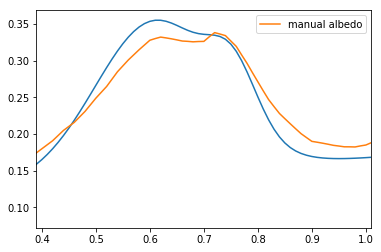

In [30]:
a1 = 0.62
b1 = 1.0
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = -0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0001

a4 = 0.584
b4 = 0.35
c4 = 0.01
d4 = 0.0001

x = np.array(myalbed['wav'])
#x = cube.waves/1000.
y = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
     ((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3) + ((b4/(2*np.pi))*np.exp(-((x-a4)**2)/(2*c4))+d4))
plt.plot(x, y)
plt.plot(myalbed['wav'], myalbed['alb'], label='manual albedo')
plt.xlim(0.390,1.010)
plt.legend()

0.029331207275390625


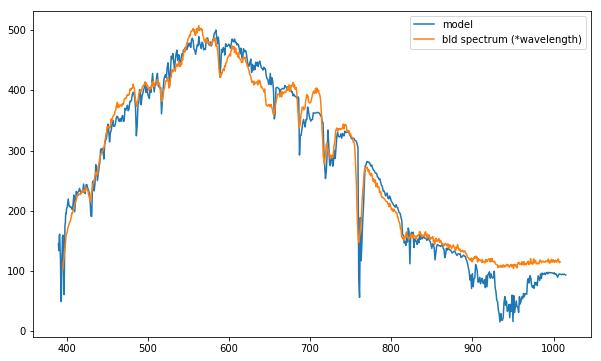

In [22]:
a1 = 0.62
b1 = 1.0
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = -0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0001

a4 = 0.584
b4 = 0.35
c4 = 0.01
d4 = 0.0001

TAIR = 15.5
RH = 69.0
TDAY = 12.5

W = 2.0
AbO3 = 0.33
ApCH2O = 0.007
#ApCH4 = 0.3
#ApCO = 0.35
ApCO = 0.0
ApHNO2 = 0.002
#ApHNO3 = 0.005
ApHNO3 = 0.0
#ApNO = 0.2
ApNO = 0.0
ApNO2 = 0.02
ApNO3 = 5e-5
ApO3 = 0.053
ApSO2 = 0.05
#qCO2 = 370.0
qCO2 = 0.0
ALPHA1 = 0.9111
ALPHA2 = 1.3529
OMEGL = 0.8
GG = 0.7
TAU5 = 0.084
    
amp = 2010.

t0 = time.time()
modwav, maxmod = modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                           TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, 
                           ApNO3, ApO3, ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp)
print(time.time() - t0)

fig = plt.subplots(figsize=(10,6))
plt.plot(modwav, maxmod*amp, label='model')
plt.plot(cube.waves, nblds, label='bld spectrum (*wavelength)')
plt.legend()
plt.show()

In [23]:
def albedoFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4):
    albedo = ((b1/(2*np.pi))*np.exp(-((wav-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((wav-a2)**2)/(2*c2))+d2) + \
    ((b3/(2*np.pi))*np.exp(-((wav-a3)**2)/(2*c3))+d3) + ((b4/(2*np.pi))*np.exp(-((wav-a4)**2)/(2*c4))+d4)
    
    return np.array(albedo)

In [24]:
def modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
              TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, 
              ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5):
    nalb = 101
    mywav = np.linspace(0.3,1.3,nalb)
    np.around(mywav, 2, mywav)
    albedo = albedoFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    np.around(albedo, 4, albedo)

    #TAIR = 15.5
    #RH = 69.0
    #TDAY = 12.5
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    albwav = np.zeros(shape=(3000))
    albalb = np.zeros(shape=(3000))
    l = np.zeros(shape=(14,636))
    #c = np.zeros(shape=(6,851))
    albwav[:nalb] = mywav
    albalb[:nalb] = albedo
    
    pymod = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, 0.0, 0.0, ApHNO2, 
                             ApHNO3, 0.0, ApNO2, ApNO3, ApO3, ApSO2, 0.0, 
                             ALPHA1, ALPHA2, OMEGL, GG, TAU5, 1, 1,
                             albwav, albalb, nalb, Year, Month, Day, Hour, l)
    
#    interp_l = interp1d(pymod[0], pymod[-2], fill_value="extrapolate")
#    model = np.array(interp_l(wav)) * amp
    
    return pymod[0], pymod[-2]

In [25]:
def interpModel(mywav, amp, modelwav, modelsmrt):
    interpMod = interp1d(modelwav, modelsmrt, fill_value="extrapolate")
    model = np.array(interpMod(mywav)) * amp
    
    return model

In [33]:
'''
def log_prior(theta, wav, model):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, \
    ApNO3, ApO3, ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = theta
    if eps <= 0:
        print("**eps < 0", eps)
        return -np.inf
    if (c1 == 0) or (c2 == 0) or (c3 == 0) or (c4 == 0):
        print("**C = ", c1, c2, c3, c4)
        return -np.inf
    if (amp <= 0):
        print("**amplitude = ", amp)
        return -np.inf
    nwav = wav/1000.
    albedo = albedoFunc(nwav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    if (any(albedo) < 0) or (any(albedo) > 1):
        print('**Albedo not in 0-1 range')
        return -np.inf
    if ((TAIR > 40) or (TAIR < -25) or
        (RH < 0) or (RH > 100) or
        (TDAY > 40) or (TDAY < -25) or
        (W > 12) or 
        (AbO3 < 0) or (AbO3 > 5.0) or 
        (ApCH2O < 0) or (ApCH2O > 5.0) or  
        (ApCO < 0) or (ApCO > 5.0) or 
        (ApHNO2 < 0) or (ApHNO2 > 5.0) or
        (ApHNO3 < 0) or (ApHNO3 > 5.0) or
        (ApNO < 0) or (ApNO > 5.0) or
        (ApNO2 < 0) or (ApNO2 > 5.0) or
        (ApNO3 < 0) or (ApNO3 > 5.0) or
        (ApO3 < 0) or (ApO3 > 5.0) or
        (ApSO2 < 0) or (ApSO2 > 5.0) or
        (qCO2 < 0) or (qCO2 > 1000) or
        (ALPHA1 < 0) or (ALPHA1 > 2.7) or
        (ALPHA2 < 0) or (ALPHA2 > 2.7) or
        (OMEGL < 0.01) or (OMEGL > 1.0) or
        (GG < 0.01) or (GG > 1.0) or
        (TAU5 < 0) or (TAU5 > 1.0)):
        print("**Parameter problem ", theta)
        return -np.inf
    if any(np.isnan(model)):
        print("**Model NAN", theta)
        return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,  \
    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, \
    ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = theta
    
    model = modelFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3,
                      a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, 
                      ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp)
    
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, \
    ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = theta
    
    model = modelFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3,
                      a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O, ApCO, ApHNO2, ApHNO3, 
                      ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp)
    
    lp = log_prior(theta, wav, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)
'''

In [26]:
def log_likelihood(theta, wav, y):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3,  \
    ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = theta
    
    modelwav, modelsmrt = modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3,
                                    a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O, 
                                    ApHNO2, ApHNO3, ApNO2, ApNO3, ApO3, ApSO2, ALPHA1, 
                                    ALPHA2, OMEGL, GG, TAU5)
    modelwav, modelsmrt = modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3,
                                    a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O,
                                    ApHNO2, ApHNO3, ApNO2, ApNO3, ApO3, ApSO2, ALPHA1, 
                                    ALPHA2, OMEGL, GG, TAU5)
    
    model = interpModel(wav, amp, modelwav, modelsmrt)
    
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    print(lp)
    return lp

## Maximum Likelihood
### albedo parameters, amplitude, offset 

In [27]:
## -- Maximum Likelihood function

def MaxLikFunc(blds, wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3,
               a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3,
               ApNO2, ApNO3, ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp):
    #np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, 
                        a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3,
                        ApNO2, ApNO3, ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, 20.])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [28]:
cube.waves[-200]

858.69

In [29]:
print("Maximum Likelihood results:")

a1 = 0.62
b1 = 1.0
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = -0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0001

a4 = 0.584
b4 = 0.35
c4 = 0.01
d4 = 0.0001

TAIR = 15.5
RH = 69.0
TDAY = 12.5

W = 2.0
AbO3 = 0.33
ApCH2O = 0.007
#ApCH4 = 0.3
#ApCO = 0.35
ApHNO2 = 0.002
ApHNO3 = 0.005
#ApNO = 0.2
ApNO2 = 0.02
ApNO3 = 5e-5
ApO3 = 0.053
ApSO2 = 0.05
#qCO2 = 370.0
ALPHA1 = 0.9111
ALPHA2 = 1.3529
OMEGL = 0.8
GG = 0.7
TAU5 = 0.084
    
amp = 2000.

import time
start_time = time.time()
result = MaxLikFunc(nblds[:-200], cube.waves[:-200], a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3,
                    a4, b4, c4, d4, TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3,
                    ApNO2, ApNO3, ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Maximum Likelihood results:
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.1478491859775
-2922.147849186328
-2922.1478490944255
-2922.1478491859775
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219261783
-2917.9049219

-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287526
-2916.963070287525
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2916.9630702919458
-2

-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875234
-2916.9630702875243
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875234
-2916.9630702875243
-2916.9630702875206


-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875234
-2916.9630702875243
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875234
-2916.9630702875243
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206


-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875234
-2916.9630702875243
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215
-2916.9630702875215


-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875234
-2916.9630702875243
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206
-2916.9630702875206


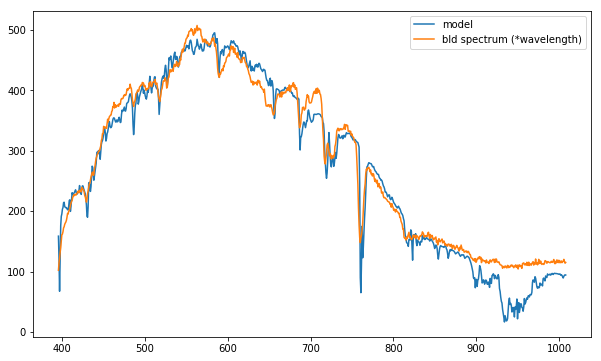

In [30]:
#maxmod = modelFunc(cube.waves, result.x[0],result.x[1],result.x[2],result.x[3],result.x[4],result.x[5],result.x[6]
#                   ,result.x[7],result.x[8],result.x[9],result.x[10],result.x[11],result.x[12])
modwav, modsmrt = modelFunc(*result.x[:-2])
model = interpModel(cube.waves, result.x[-2], modwav, modsmrt)

fig = plt.subplots(figsize=(10,6))
plt.plot(cube.waves, model, label='model')
plt.plot(cube.waves, nblds, label='bld spectrum (*wavelength)')
plt.legend()
plt.show()

## MCMC
### albedo parameters, amplitude, offset 

In [31]:
def log_prior(theta, wav, model):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3,  \
    ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = theta
    if eps <= 0:
        print("**EPS = ", eps)
        return -np.inf
    if (c1 == 0) or (c2 == 0) or (c3 == 0) or (c4 == 0):
        print("**C = ", c1, c2, c3, c4)
        return -np.inf
    if (amp <= 0):
        print("**Amplitude = ", amp)
        return -np.inf
    nwav = wav/1000.
    albedo = albedoFunc(nwav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    if (any(albedo) < 0) or (any(albedo) > 1):
        print("**ALBEDO not in 0-1 range:", a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
        return -np.inf
    if ((TAIR > 40) or (TAIR < -25) or
        (RH < 0) or (RH > 100) or
        (TDAY > 40) or (TDAY < -25) or
        (W < 0) or (W > 12) or
        (AbO3 < 0) or (AbO3 > 5.0) or 
        (ApCH2O < 0) or (ApCH2O > 5.0) or  
        (ApHNO2 < 0) or (ApHNO2 > 5.0) or
        (ApHNO3 < 0) or (ApHNO3 > 5.0) or
        (ApNO2 < 0) or (ApNO2 > 5.0) or
        (ApNO3 < 0) or (ApNO3 > 5.0) or
        (ApO3 < 0) or (ApO3 > 5.0) or
        (ApSO2 < 0) or (ApSO2 > 5.0) or
        (ALPHA1 < 0) or (ALPHA1 > 5.0) or
        (ALPHA2 < 0) or (ALPHA2 > 5.0) or
        (OMEGL < 0.001) or (OMEGL > 1.0) or
        (GG < 0.001) or (GG > 1.0) or
        (TAU5 < 0) or (TAU5 > 1.0)):
        print("**PARAMETERS issue: ", theta)
        return -np.inf
    if (any(model) < 0):
        return -np.inf
    return 0.0

def log_likelihood(eps, model, y):  
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3,  \
    ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = theta
    
    modwav, modsmrt = modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, 
                                TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, 
                                ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5)
    if any(np.isnan(modsmrt)):
        modwav, modsmrt = modelFunc(a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, 
                                    TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, 
                                    ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5)
        if any(np.isnan(modsmrt)):
            print("**MODEL has NaN:", theta)
            print("LOG_PROBABILITY = ", -np.inf)
            return -np.inf
        
    model = interpModel(wav, amp, modwav, modsmrt)
    
    lp = log_prior(theta, wav, model)
    if not np.isfinite(lp):
        print("LOG_PROBABILITY = ", -np.inf)
        return -np.inf
    
    lk = log_likelihood(eps, model, y)
    lprb = lp + lk
    print("LOG_PROBABILITY = ", lprb)
    return lprb

In [32]:
nwalkers, ndim = 100, result.x.shape[0]
p0 = result.x * (1 + np.random.randn(nwalkers, ndim)/1000.)

In [33]:
print(nwalkers, ndim)

100 35


In [146]:
# -- emcee: some builds of Numpy auto parallelize some operations
#    can cause problems ==> good to turn off
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [147]:
from multiprocessing import cpu_count
print(cpu_count())

112


In [ ]:
# -- Sample the distribution using emcee
#    start by initializing the walkers in a small gaussian ball around the max. likelihood
#    run 10000 steps of MCMC (5000 resulted in message: 
#    "The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). 
#     Use this estimate with caution and run a longer chain!")

#from multiprocessing import Pool

# make wavelengths and building spectra global variables
mywav = cube.waves[:-200]
myblds = nblds[:-200]

start_time = time.time()

#with Pool() as pool:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)#, pool=pool)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mywav, myblds))
sampler.run_mcmc(p0, 50000)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [94]:
def modelFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
              TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, 
              ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp):
    nalb = 101
    mywav = np.linspace(0.3,1.3,nalb)
    np.around(mywav, 2, mywav)
    albedo = albedoFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    np.around(albedo, 4, albedo)

    #TAIR = 15.5
    #RH = 69.0
    #TDAY = 12.5
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    albwav = np.zeros(shape=(3000))
    albalb = np.zeros(shape=(3000))
    l = np.zeros(shape=(14,636))
    #c = np.zeros(shape=(6,851))
    albwav[:nalb] = mywav
    albalb[:nalb] = albedo
    
    pymod = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, 0.0, 0.0, ApHNO2, 
                             ApHNO3, 0.0, ApNO2, ApNO3, ApO3, ApSO2, 0.0, 
                             ALPHA1, ALPHA2, OMEGL, GG, TAU5, 1, 1,
                             albwav, albalb, nalb, Year, Month, Day, Hour, l)
    
    return pymod

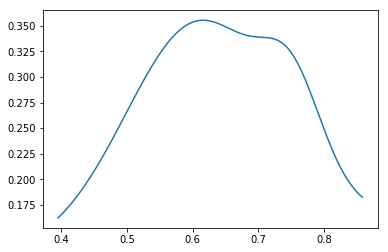

In [117]:
res = [6.20380232e-01, 9.99726250e-01, 1.30253186e-02, 1.00184691e-01,
  7.52390639e-01,  4.70165946e-01,  1.99635605e-03, -9.97968935e-03,
  1.90119445e+00,  6.98546314e-01,  1.09743903e+00,  9.99746537e-05,
  5.84863606e-01,  3.50001687e-01,  1.00065405e-02,  9.98910286e-05,
  1.55240159e+01,  6.89023399e+01,  1.24731702e+01,  1.99758009e+00,
  3.30197012e-01,  6.99698756e-03,  2.00180214e-03,  5.00188334e-03,
  2.00283953e-02,  5.00886851e-05,  5.29548100e-02,  4.98962650e-02,
  9.12438375e-01,  1.35031878e+00,  7.99108341e-01,  6.99311453e-01,
  8.40631955e-02,  1.99907201e+03,  1.99709706e+01]
a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4, \
TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3,  \
ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp, eps = res

albs = albedoFunc(mywav/1000., a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
plt.plot(mywav/1000., albs)
plt.show()
model1 = modelFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                   TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3,
                   ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp)
for i in range(0,100):
    model2 = modelFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
              TAIR, RH, TDAY, W, AbO3, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3,
              ApO3, ApSO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, amp)
    diff = model2[-2] - model1[-2]
    plt.plot(model2[0], diff)
    model1 = model2
plt.show()
#interp_l = interp1d(pymod[0], pymod[-2], fill_value="extrapolate")
#model = np.array(interp_l(wav)) * amp

In [ ]:
fig, axes = plt.subplots(ndim, sharex=True, figsize=(8,40))
labels = ['a1', 'b1', 'c1', 'd1',
          'a2', 'b3', 'c2', 'd2',
          'a3', 'b3', 'c3', 'd3',
          'a4', 'b4', 'c4', 'd4',
          'T_air', 'R.Humid', 'T_day',          
          'H2O', 'AbO3', 'ApCH2O', 'ApHNO2', 'ApHNO3', 'ApNO2', 'ApNO3',
          'ApO3', 'ApSO2', 'ALPHA1', 'ALPHA2', 'OMEGL', 'GG', 'TAU5', 'amp', 'eps']
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial steps (~3 x tau)
#    thin by ~(0.5 x tau)
#    flatten the chain

flat_samples = sampler.get_chain(discard=3000, thin=500, flat=True)
print(flat_samples.shape)

In [ ]:
f, ax = plt.subplots(35, 35, figsize=(70,70))
labels = ['a1', 'b1', 'c1', 'd1',
          'a2', 'b3', 'c2', 'd2',
          'a3', 'b3', 'c3', 'd3',
          'a4', 'b4', 'c4', 'd4',
          'H2O', 'AbO3', 'ApCH2O', 'ApCO', 'ApHNO2', 'ApHNO3', 'ApNO', 'ApNO2', 'ApNO3',
          'ApO3', 'ApSO2', 'qCO2', 'ALPHA1', 'ALPHA2', 'OMEGL', 'GG', 'TAU5', 'amp', 'eps']
fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0), fig=f)
f.savefig('./corner.png', dpi=300)

In [ ]:
fig = plt.subplots(figsize=(10,6))
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    maxmod = modelFunc(cube.waves,*sample[:-1])
    linm, = plt.plot(cube.waves, maxmod, color='dodgerblue', lw=0.3)
linb, = plt.plot(cube.waves, nblds, color='darkred')
plt.xlabel('wavelength [nm]')
plt.legend([linb, linm], ['data', 'model'])
plt.show()

In [ ]:
cube_reshaped = cube_sub.transpose(1,2,0).reshape((cube_sub.shape[1]*cube_sub.shape[2]), cube_sub.shape[0])
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)

In [ ]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])

In [ ]:
cube.waves[-80]

In [ ]:
fig, ax = plt.subplots(figsize=[8,8])
ax.imshow(cube.data[-80],aspect=0.5)
plt.show()

fig, ax = plt.subplots(figsize=[8,8])
ax.imshow(cube_std_3d[:,:,-80],aspect=0.5)
plt.show()

In [ ]:
print(cube.waves.min(), cube.waves.max())

296.5 384.5


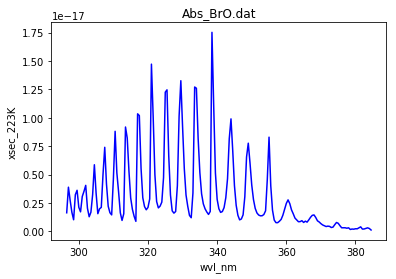

280.0 400.0


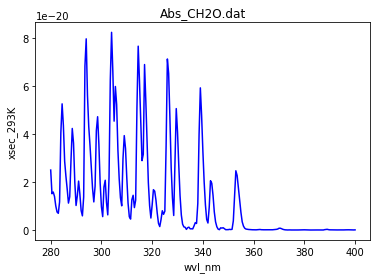

1617 4000


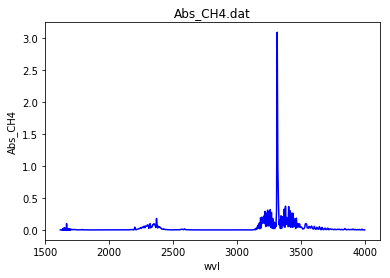

280.0 432.0


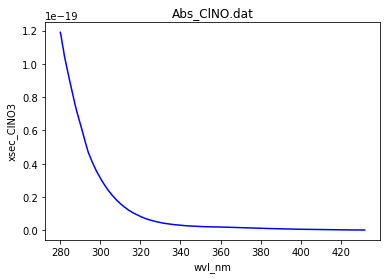

1036 4000


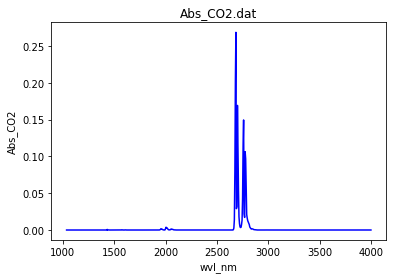

2310 2405


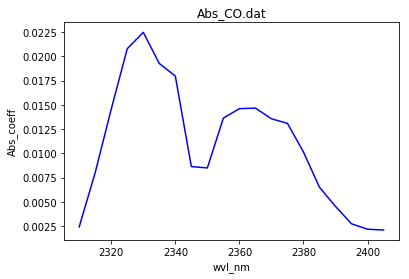

440.0 4000.0


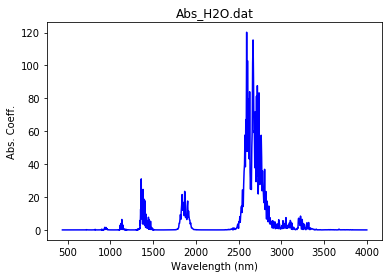

300.5 396.5


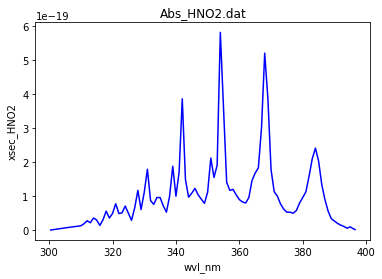

280.0 350.0


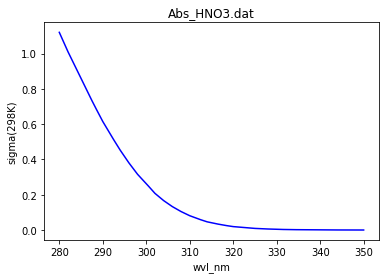

3645 4000


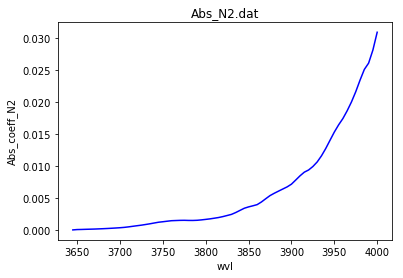

1950 4000


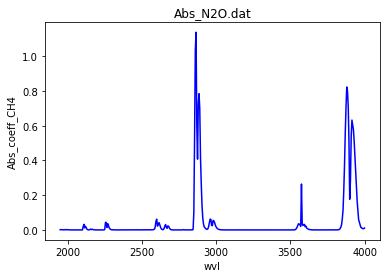

1900 4000


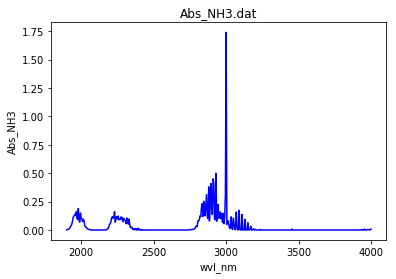

280.0 926.0


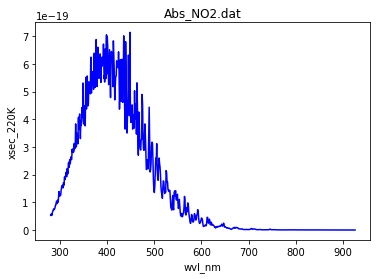

400 703


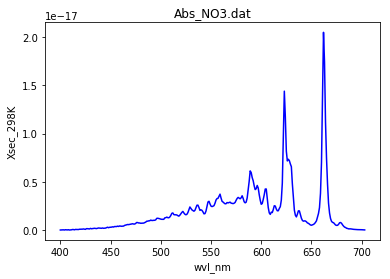

2645 2745


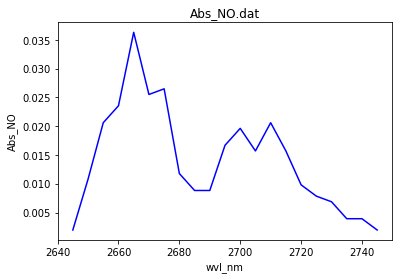

627 1581


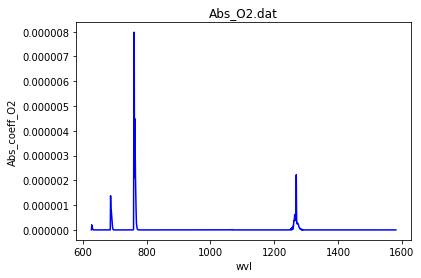

2470 4000


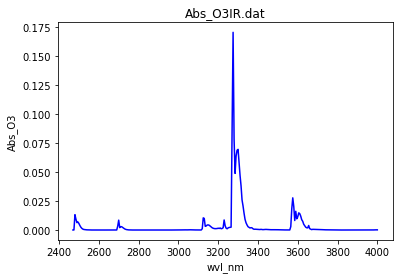

280.0 1091.0


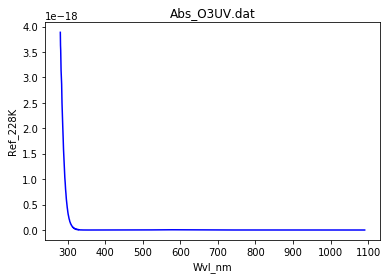

280.0 1593.0


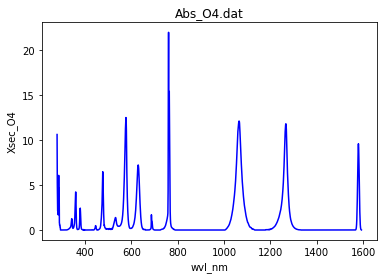

3955 4000


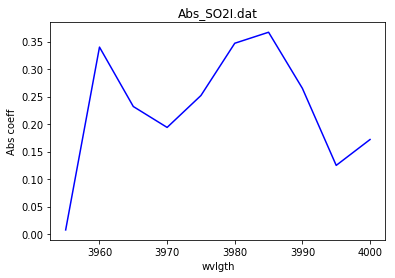

280.0 420.0


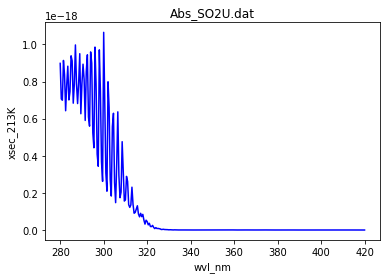

In [12]:
GasFiles = !ls ./Gases/
for file in GasFiles:
    filename = './Gases/' + file
    gas = pd.read_csv(filename, sep='\t')
    hd = np.array(gas.keys())
    print(gas[hd[0]].min(), gas[hd[0]].max())
    plt.plot(gas[hd[0]], gas[hd[1]], color='b')
    plt.xlabel(hd[0])
    plt.ylabel(hd[1])
    plt.title(file)
    plt.show()

## Least Squares Fit

In [ ]:
## -- using least squares fit to find best parameters
from scipy.interpolate import interp1d

def func(wav, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2,
                qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, IALBDX, Ialbdg,amp):
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    
    TAIR = 15.5
    RH = 69.0
    TDAY = 12.5
    #IALBDX = 18
    #Ialbdg = 18
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    l,c = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, 
                             ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2, 
                             ALPHA1, ALPHA2, OMEGL, GG, TAU5, int(IALBDX), int(Ialbdg),
                             Year, Month, Day, Hour,l,c)
    
    interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
    model = interp_l(wav)
    
    return model*amp

In [ ]:
from scipy.optimize import curve_fit

popt, popcov = curve_fit(func, cube.waves, blds*cube.waves/1e3, p0=(12.0,0.35,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                                                     5e-5,0.053,0.05,370.0,0.9111,1.3529,0.8,0.7,0.084,
                                                     18,18,2200), 
                         bounds=([0.,.2,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,350.,0.,0.,.6,.5,0.,2,2,0.],
                                 [12.,.5,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,400.,2.6,2.6,1.,.9,.5,66,66,10000.]))

In [ ]:
popt

In [ ]:
#plt.plot(cube.waves, blds*cube.waves/1e3, color='black', label='Mean Building Spectrum (*wavelength)')
plt.plot(cube.waves, myl, label='Model')

## MCMC

In [ ]:
from scipy.interpolate import interp1d

def func(wav, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2,
                qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5):
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    
    TAIR = 15.5
    RH = 69.0
    TDAY = 12.5
    IALBDX = 18
    Ialbdg = 18
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    l,c = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, 
                             ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2, 
                             ALPHA1, ALPHA2, OMEGL, GG, TAU5, int(IALBDX), int(Ialbdg),
                             Year, Month, Day, Hour,l,c)
    
    interp_c = interp1d(c[0], c[5], fill_value="extrapolate")
    model = interp_c(wav)
    
    return model*1000.

In [ ]:
def log_prior(theta):
    W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, \
    ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, offset, eps = theta
    if ((W > 12) or 
        (AbO3 < 0.1) or (AbO3 > 0.6) or 
        (ApCH2O < 0) or (ApCH2O > 2.0) or 
        (ApCH4 < 0) or (ApCH4 > 2.0) or 
        (ApCO < 0) or (ApCO > 2.0) or 
        (ApHNO2 < 0) or (ApHNO2 > 2.0) or
        (ApHNO3 < 0) or (ApHNO3 > 2.0) or
        (ApNO < 0) or (ApNO > 2.0) or
        (ApNO2 < 0) or (ApNO2 > 2.0) or
        (ApNO3 < 0) or (ApNO3 > 2.0) or
        (ApO3 < 0) or (ApO3 > 2.0) or
        (ApSO2 < 0) or (ApSO2 > 2.0) or
        (qCO2 < 350) or (qCO2 > 450) or
        (ALPHA1 < 0) or (ALPHA1 > 2.7) or
        (ALPHA1 < 0) or (ALPHA2 > 2.7) or
        (OMEGL < 0.5) or (OMEGL > 1.0) or
        (GG < 0.4) or (GG > 1.0) or
        (TAU5 < 0) or (TAU5 > 1.0) or
        (eps <= 0)):
        return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, \
    ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, offset, eps = theta
    model = func(wav, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, 
                 ApNO3, ApO3, ApSO2,qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5) + offset
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)

In [ ]:
## -- Maximum Likelihood function
from scipy.optimize import minimize

def MaxLikFunc(blds, wav, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,5e-5,0.053,0.05,
                        370.0,0.9111,1.3529,0.8,0.7,0.084,0.0,1.0])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [ ]:
print("Maximum Likelihood results:")

import time
start_time = time.time()
result = MaxLikFunc(blds, cube.waves, random_seed=123)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
plt.plot(cube.waves, blds, color='black', label='Mean Building Spectrum')
plt.plot(cube.waves, func(cube.waves, *result.x[:-2])+result.x[-2], label='model')
plt.title('Maximum Likelihood')
plt.legend()
plt.show()

In [ ]:
nwalkers, ndim = 50, 20
p0 = 

## Looking at Sky Spectra

In [ ]:
srow = np.arange(795,800)
scol = np.arange(847,852)
scoords = np.vstack(np.meshgrid(srow, scol)).reshape(2,-1).T
print(scoords.shape)
for coord in scoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
sky = cube.data[:,795:800,847:852].mean(axis=(1,2))
plt.plot(cube.waves, sky, color='blue')
plt.show()

In [ ]:
fig = plt.subplots(figsize=(15,8))
i=1
for label in llabels:
    plt.plot(l[0], l[i]*3000, label=label)
    i=i+1
plt.plot(cube.waves, sky, color='black', label='Mean Building Spectrum')
plt.legend()
#plt.ylim(0,3000)
plt.show()

In [ ]:
fig = plt.subplots(figsize=(10,6))
plt.plot(l1[0], l1[8]*5000, label='low water')
plt.plot(l2[0], l2[8]*5000, label='high water')
plt.plot(cube.waves, sky, color='black', label='Mean Building Spectrum')
plt.legend()
plt.title(clabels[4])
plt.show()

## Vegetation Spectrum

In [ ]:
vrow = np.arange(1090,1095)
vcol = np.arange(890,895)
vcoords = np.vstack(np.meshgrid(vrow, vcol)).reshape(2,-1).T
print(vcoords.shape)
for coord in vcoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
veg = cube.data[:,1090:1095,890:895].mean(axis=(1,2))
plt.plot(cube.waves, veg, color='black')
plt.show()

In [ ]:
plt.plot(cube.waves, veg*cube.waves/1e3, color='black')
plt.show()

In [ ]:
fig = plt.subplots(figsize=(15,8))
valbedos = [17,22,25,47,53,54,62,66]
alblabel = ['Ponderosa Pine','Conifer Trees','Deciduous Trees','Birch','Oak','Pinion Pine','Fir','Spruce']
i=0
for albedo in valbedos:
    l1 = np.zeros(shape=(14,636))
    c1 = np.zeros(shape=(6,851))
    l1,c1 = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                               5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,18,albedo,
                               2016,5,5,14.02,l1,c1)
    plt.plot(l1[0], l1[-2]*4200, label=alblabel[i])
    i+=1
plt.plot(cube.waves, veg*cube.waves/1e3, color='black')
plt.legend()
plt.show()

## ALBEDO

In [ ]:
## -- using least squares fit to find best parameters
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

def func(wav, alb):
    mywav = np.arange(300, 1310, 10)
    tocsv = pd.DataFrame({'wav':[], 'alb':[]})
    tocsv['wav'] = mywav/1000.
    tocsv['alb'] = alb
    tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))
    
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                             5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                             2016,5,5,14.02,l,c)
    
    interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
    model = interp_l(wav)
    
    return model

In [ ]:
from scipy.optimize import curve_fit
myalbed['alb']
popt, popcov = curve_fit(func, cube.waves, blds, bounds=(np.zeros(850), np.ones(850)))

In [ ]:
def log_prior(theta):
    if theta[-1] <= 0:
        return -np.inf
    for i in range(len(theta)-3):
        if (theta[i] < 0) or (theta[i] > 1):
            return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    model = (func(wav, theta[:-3]) * theta[-3]) + theta[-2]
    denom = theta[-1]**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)

In [ ]:
## -- Maximum Likelihood function
from scipy.optimize import minimize

def MaxLikFunc(blds, wav, myalbedo, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.append(myalbedo, [2200,0,1])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [ ]:
print("Maximum Likelihood results:")

nblds = blds*cube.waves/1e3

import time
start_time = time.time()
result = MaxLikFunc(nblds, cube.waves, myalbed['alb'][:-1], random_seed=123)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
plt.plot(myalbed['wav'][:-1], result.x[:-3])
plt.xlim(0.390,1.010)

In [ ]:
from scipy.ndimage import gaussian_filter1d

myalbsmooth = gaussian_filter1d(result.x[:-3],10)

plt.plot(myalbed['wav'][:-1], myalbsmooth)
plt.xlim(0.390,1.010)

In [ ]:
fig = plt.subplots(figsize=(10,6))
plt.plot(cube.waves, (func(cube.waves, result.x[:-3])*result.x[-3])+result.x[-2], label='Model')
plt.plot(cube.waves, (func(cube.waves, myalbsmooth)*result.x[-3])+result.x[-2], label='Model smoothed')
plt.plot(cube.waves, blds*cube.waves/1e3, color='black', label='Mean Building Spectrum')
plt.legend()
plt.show()

In [ ]:
a = 0.67
b = 0.99
c = 0.032
d = 0.15
x = np.linspace(0.3,1.1,100)
y = (b/(2*np.pi))*np.exp(-((x-a)**2)/(2*c))+d
plt.plot(x, y)
plt.plot(myalbed['wav'][:-1], myalbsmooth)
plt.xlim(0.390,1.010)

In [ ]:
from scipy.interpolate import interp1d

def func(wav, a, b, c, d, amp, offset):
    mywav = np.linspace(0.3,1.31,100)
    tocsv = pd.DataFrame({'wav':[], 'alb':[]})
    tocsv['wav'] = mywav
    tocsv['alb'] = (b/(2*np.pi))*np.exp(-((mywav-a)**2)/(2*c))+d
    tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))
    
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                             5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                             2016,5,5,14.02,l,c)
    
    interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
    model = (np.array(interp_l(wav)) * amp) + offset
    
    return model

In [ ]:
def log_prior(theta):
    a, b, c, d, amp, offset, eps = theta
    if theta[-1] <= 0:
        return -np.inf
    if c == 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    a, b, c, d, amp, offset, eps = theta
    model = func(wav, a, b, c, d, amp, offset)
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)

In [ ]:
## -- Maximum Likelihood function
from scipy.optimize import minimize

def MaxLikFunc(blds, wav, a0, b0, c0, d0, amp0, offset0, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([a0, b0, c0, d0, amp0, offset0, 1])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [ ]:
print("Maximum Likelihood results:")

nblds = blds*cube.waves/1e3

a0 = 0.67
b0 = 0.99
c0 = 0.032
d0 = 0.15
amp0 = 2200.
offset0 = 0.0

import time
start_time = time.time()
result = MaxLikFunc(nblds, cube.waves, a0, b0, c0, d0, amp0, offset0, random_seed=123)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
plt.plot(cube.waves, func(cube.waves, result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5]))
plt.plot(cube.waves, nblds)

In [ ]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = np.array(myalbed['wav'])
y = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
     (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
plt.plot(x, y)
myalbed = pd.read_csv('./Albedo/myALBEDO.DAT', sep='\t', header=None, names=['wav', 'alb'])
plt.plot(myalbed['wav'], myalbed['alb'])
plt.xlim(0.390,1.010)
plt.show()

In [ ]:
# -- using least squares fit to find minimums for albedo

def func(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3):
    model = ((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) + \
            ((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)
    
    return model

In [ ]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = myalbed['wav']
tocsv = pd.DataFrame({'wav':[], 'alb':[]})
tocsv['wav'] = x
tocsv['alb'] = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
                (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

l = np.zeros(shape=(14,636))
c = np.zeros(shape=(6,851))
l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         2016,5,5,14.02,l,c)

interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
model1 = np.array(interp_l(cube.waves))

In [ ]:
!cp ./Albedo/myALBEDO.DAT ./Albedo/ALBEDO.DAT


l = np.zeros(shape=(14,636))
c = np.zeros(shape=(6,851))
l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         2016,5,5,14.02,l,c)

interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
model2 = np.array(interp_l(cube.waves))

In [ ]:
plt.plot(cube.waves, model1*2000, label='tri-model model')
plt.plot(cube.waves, model2*2000, label='hand-made model')
plt.plot(cube.waves, nblds, label='buildings', color='black')
plt.legend()
plt.show()

## Using ratio of albedos on vegetation

In [ ]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = myalbed['wav']
tocsv = pd.DataFrame({'wav':[], 'alb':[]})
tocsv['wav'] = x
tocsv['alb'] = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
                (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

l = np.zeros(shape=(14,636))
c = np.zeros(shape=(6,851))
l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         2016,5,5,14.02,l,c)

interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
bld_model = np.array(interp_l(cube.waves))

plt.plot(cube.waves, bld_model*2000, label='model')
plt.plot(cube.waves, nblds, label='buildings', color='black')
plt.legend()
plt.show()

In [ ]:
bld_alb = pd.read_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, names=['wav', 'alb'])
conc_alb = pd.read_csv('./Albedo/CONCRETE.DAT', sep='\t', header=None, names=['wav', 'alb'])

plt.plot(bld_alb['wav'], bld_alb['alb'], label="best fit albedo")
plt.plot(conc_alb['wav'], conc_alb['alb'], label = "concrete albedo")
plt.xlim(0.390,1.010)
plt.legend(loc='upper left')
plt.show()

In [ ]:
albratio = np.array(bld_alb['alb'][:-1]) / np.array(conc_alb['alb'][:-1])
plt.plot(bld_alb['wav'][:-1], albratio)
plt.title('Building Albedo Ratio')
plt.show()

In [ ]:
albfiles = !ls ./myAlbedo/
alb = {}
for file in albfiles:
    filename = './myAlbedo/' + file
    alb[file] = pd.read_csv(filename, sep='\t', header=None, names=['wav', 'alb'])

fig = plt.subplots(figsize=(10,6))

plt.title('Vegetation Albedos')

for key in alb.keys():
    if key.startswith('V'):
        plt.plot(alb[key]['wav'], alb[key]['alb'], label=key)

plt.xlim(0.390,1.010)
plt.legend(bbox_to_anchor=(-0.175,1.0))
plt.show()

In [ ]:
fig = plt.subplots(figsize=(10,6))

plt.title('Vegetation Albedos (in proper range)')

for key in alb.keys():
    if key.startswith('V'):
        if (np.array(alb[key]['wav'][:-1]).min() <= 0.4) and (np.array(alb[key]['wav'][:-1]).max() >= 1.0):
            print(key, np.array(alb[key]['wav'][:-1]).min(), np.array(alb[key]['wav'][:-1]).max())
            interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                                  fill_value="extrapolate")
            valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1])))
            plt.plot(np.array(bld_alb['wav'][:-1]), valb, label=key)

plt.xlim(0.390,1.010)
plt.legend(bbox_to_anchor=(-0.175,1.0))
plt.show()

In [ ]:
fig = plt.subplots(figsize=(10,6))

plt.title('Vegetation Albedos * Albedo Ratio')
vegalbs = ['17','22','25','47','53','54','62']

for key in alb.keys():
    mykey = key.split('_')
    #if mykey[1] in vegalbs:
    if key.startswith('V'):
        print(key, np.array(alb[key]['wav'][:-1]).min(), np.array(alb[key]['wav'][:-1]).max())
        interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                              fill_value="extrapolate")
        valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1])))
        plt.plot(np.array(bld_alb['wav'][:-1]), valb*albratio, label=key)

plt.xlim(0.390,1.010)
plt.ylim(0,0.8)
plt.legend(bbox_to_anchor=(-0.175,1.0))
plt.show()

In [ ]:
fig = plt.subplots(figsize=(15,8))

for key in alb.keys():
    nkey = key.replace('.','_')
    mykey = nkey.split('_')
#    if mykey[1] in vegalbs: 
    if key.startswith('V'):
        if (np.array(alb[key]['wav'][:-1]).min() <= 0.4) and (np.array(alb[key]['wav'][:-1]).max() >= 1.0):
            interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                                  fill_value="extrapolate")
            valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1]))) * albratio
            tocsv = pd.DataFrame({'wav':[], 'alb':[]})
            tocsv['wav'] = np.array(bld_alb['wav'][:-1])
            tocsv['alb'] = valb
            tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

            l = np.zeros(shape=(14,636))
            c = np.zeros(shape=(6,851))
            l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                                     5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                                     2016,5,5,14.02,l,c)

            interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
            model = interp_l(cube.waves)

            plt.plot(cube.waves, model*5000, label=key)
plt.plot(cube.waves, veg*cube.waves/1e3, color='black', label='Vegetation Spectrum')
plt.legend()
plt.show()

In [ ]:
vegalbs = ['17','22','25','47','52','53','54','62']

fig, ax = plt.subplots(len(vegalbs), 1, figsize=(8,25))
i=0
for key in alb.keys():
    nkey = key.replace('.','_')
    mykey = nkey.split('_')
    if mykey[1] in vegalbs: 
#    if key.startswith('V'):
#        if (np.array(alb[key]['wav'][:-1]).min() <= 0.4) and (np.array(alb[key]['wav'][:-1]).max() >= 1.0):
        interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                              fill_value="extrapolate")
        valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1]))) * albratio
        tocsv = pd.DataFrame({'wav':[], 'alb':[]})
        tocsv['wav'] = np.array(bld_alb['wav'][:-1])
        tocsv['alb'] = valb
        tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

        l = np.zeros(shape=(14,636))
        c = np.zeros(shape=(6,851))
        l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                                 5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                                 2016,5,5,14.02,l,c)

        interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
        model = interp_l(cube.waves)

        ax[i].plot(cube.waves, model*5000, label=key)
        ax[i].plot(cube.waves, veg*cube.waves/1e3, color='black', label='Vegetation Spectrum')
        ax[i].set_ylim(0,1200)
        ax[i].legend()
        i+=1
plt.show()